# Анализ системы прогнозирования вероятности ДТП

## Введение

Заказчик проекта: каршеринговая компания.

Заказчик хочет понять, можно ли ли предсказывать ДТП, опираясь на исторические данные об авариях и участвовавших в них водителях и транспортных средств.

Чтобы это понять, заказчик ставит перед нами задачу:
- провести статистический анализ факторов, влияющих на ДТП;
- построить не менее трех моделей, оценивающих вероятность ДТП с любым повреждением транспортного средства, кроме царапин.
- выбрать лучшую модель,
- сделать анализ факторов, влияющих на предсказания лучшей модели,
- сформулировать для заказчика вывод о возможности предсказывать ДТП на основе анализа факторов и результатов модели, и дать рекомендации по расширению собираемых данных для решения или улучшения решения задачи предсказания ДТП.

Заказчика интересуют ДТП с типом виновника — только машина (car) и случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).

Для моделирования заказчик требует ограничиться данными за 2012 год.

Также заказчик выдвигает обязательное условие — учесть фактор возраста автомобиля.

### Цель проекта

Целью проекта является разработка аргументированного заключения о возможности предсказания ДТП на основании исторических данных об авариях и участвовавших в них водителях и транспортных средств, содержащего:
- анализ факторв, влияющих на ДТП, 
- пример моделей и оценку их качества,
- рекомендации по дополнительным данным, способствующим решению задачи.

### Основные этапы

В проекте мы выполнили следующие основные этапы:
- изучили предоставленные заказчиком данные;
- выполнили статистический анализ факторов, влияющих на ДТП;
- подготовили данные для обучения моделей;
- разработали три модели предсказания ДТП;
- проанализировали важность факторов для лучшей модели.

### Выводы

## Подготовка кода

### Загрузка библиотек

In [28]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

In [2]:
from dotenv import load_dotenv
from os import getenv

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns

### Инициализация

In [4]:
load_dotenv()
DB_CONFIG = {k : getenv(f"DB_{k.upper()}") for k in ['user','pwd','host','port','db']}


### Функции и классы

#### DataSource

In [5]:
class DataSource:
    """Provides database information  
    
    Stores info in self._table as dictionary:
    - table_name:
        - rows_number: int
        - fields:
            - field_name: 
                - uniques: int
                - nans: int
                - type: str
             - ...
    - ...
               
    """
    def __init__(self, user: str, pwd: str, host: str, port: int,
                 db: str) -> None:
        """Creates DataSource instance and initialized connection to the source"""

        self._tables = dict()
        _connection_url = f"postgresql://{user}:{pwd}@{host}:{port}/{db}"
        self._engine = create_engine(_connection_url)

        # initialize database tables info
        self._init_tables_list()
        self._init_tables_info()

    def _init_tables_list(self) -> None:
        """Get table list from database schema"""

        _query = """
            SELECT table_name
              FROM information_schema.tables
             WHERE table_schema='public'
               AND table_type='BASE TABLE';        
        """
        with self._engine.connect() as connection:
            result = connection.execute(_query)
            for row in result:
                    self._tables[row["table_name"]] = {
                        "fields": {},
                        "rows_number": None
                    }

    def _init_table_rows_number(self, table_name: str) -> None:
        """Counts number of rows in table_name"""

        _query = f"""
            SELECT COUNT(*) as rows_number
            FROM {table_name}
        """
        with self._engine.connect() as connection:
            result = connection.execute(_query)
            self._tables[table_name]["rows_number"] = [
                _ for row in result for _ in row
            ][0]

            
    def _init_table_fields_info(self, table_name: str) -> None:
        """Get tables fields from database schema"""

        _query = f"""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_name='{table_name}'        
        """
        with self._engine.connect() as connection:
            result = connection.execute(_query)
            for row in result:
                self._tables[table_name]["fields"][row["column_name"]] = {
                    "type": row["data_type"],
                    "uniques": 0,
                    "nans": 0
                }

    def _init_table_uniques(self, table_name: str) -> None:
        """Counts unique values in table_name fields"""

        _query = "SELECT {} FROM {}".format(
            ", ".join([
                f"COUNT(DISTINCT {_}) as unique_{_}"
                for _ in self._tables[table_name]["fields"].keys()
            ]), table_name)

        with self._engine.connect() as connection:
            result = connection.execute(_query)
            for row in result:
                for field in self._tables[table_name]["fields"].keys():
                    row_key = f"unique_{field}"
                    self._tables[table_name]["fields"][field]["uniques"] = row[
                        row_key]

    def _init_table_nans(self, table_name: str) -> None:
        """Counts number of NULL values in table_name fields"""
        
        with self._engine.connect() as connection:
            for field in self._tables[table_name]["fields"].keys():
                _query = f"""
                    SELECT COUNT(*) 
                    FROM {table_name} 
                    WHERE {field} IS NULL        
                """
                result = connection.execute(_query)
                self._tables[table_name]["fields"][field]["nans"] = [
                    _ for row in result for _ in row
                ][0]
        

    def _init_tables_info(self) -> None:
        """Get tables info from database schema"""

        for table_name in self.tables:
            print(f"Get info for {table_name}")
            print("... rows number")
            self._init_table_rows_number(table_name)
            print("... fields info")
            self._init_table_fields_info(table_name)
            print("... number of unique values")
            self._init_table_uniques(table_name)
            print("... number of nan values")
            self._init_table_nans(table_name)
            print("done")

    @property
    def tables(self) -> list:
        """Returns list of tables in the database"""
        return [*self._tables]

    def exec_query(self, query: str) -> pd.DataFrame:
        """Executes SQL query and return DataFrame"""
        return pd.read_sql_query(query, con=self._engine)

    def table_head(self, table_name: str, number: int = 5) -> pd.DataFrame:
        """Returns first number of records in table_name"""
        return self.exec_query(f"SELECT * FROM {table_name} LIMIT {number}")

    def table_info(self, table_name: str) -> None:
        """Prints table info"""

        max_field_len = max(
            [len(_) for _ in self._tables[table_name]["fields"].keys()])

        max_type_len = max([
            len(self._tables[table_name]["fields"][field]["type"])
            for field in self._tables[table_name]["fields"].keys()
        ])

        rows_title = f"Field{' '*(max_field_len - len('Field'))}" + \
            "     Uniques     NaNs" + \
            "  Type" + (" "  * (max_type_len - len("Type")))
        print(f"Table: {table_name}")
        print(f"{self._tables[table_name]['rows_number']:,d} rows")
        print("-" * len(rows_title))
        print(rows_title)
        print("-" * len(rows_title))

        for k, v in self._tables[table_name]["fields"].items():
            print(f"{k}{' '*(max_field_len - len(k))}  " +
                  f"{v['uniques']:10,d} {v['nans']:8,d}  {v['type']}")
        print()

## Первичное исследование данных

### Описание данных от заказчика

Заказчик предоставил нам следующую схему и описание данных.

![ER-диаграмма](https://pictures.s3.yandex.net/resources/1.7_2880border_1_1654004672.png)

#### collisions — общая информация о ДТП
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда

|Описание |Обозначение в таблице |Значения|
|:---|:---|:---|
|Идентификационный номер в базе данных| CASE_ID| Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
|Дата происшествия|COLLISION_DATE|Формат год/месяц/день|
|Время происшествия|COLLISION_TIME|Формат: 24-часовой|
|Является ли место происшествие перекрёстком|INTERSECTION|Y — Intersection (перекрёсток)<br/>N — Not Intersection (не перекрёсток)<br/>-- — Not stated (Не указано)|
|Погода|WEATHER_1|A — Clear (Ясно)<br/>B — Cloudy (Облачно)<br/>C — Raining (Дождь)<br/>D — Snowing (Снегопад)<br/>E — Fog (Туман)<br/>F — Other (Другое)<br/>G — Wind (Ветер)- — Not Stated (Не указано)|
|Серьёзность происшествия|COLLISION_DAMAGE|1 — FATAL ТС (Не подлежит восстановлению)<br/>2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)<br/>3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)<br/>4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)<br/>0 – SCRATCH (Царапина)|
|Основной фактор аварии|PRIMARY_COLL_FACTOR|A — Code Violation (Нарушение правил ПДД)<br/>B — Other Improper Driving (Другое неправильное вождение)<br/>C — Other Than Driver (Кроме водителя)<br/>D — Unknown (Неизвестно)<br/>E — Fell Asleep (Заснул)<br/>- — Not Stated (Не указано)|
|Состояние дороги|ROAD_SURFACE|A — Dry (Сухая)<br/>B — Wet (Мокрая)<br/>C — Snowy or Icy (Заснеженная или обледенелая)<br/>D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)<br/>- — Not Stated (Не указано)|
<br/>Освещение|LIGHTING|A — Daylight (Дневной свет)<br/>B — Dusk-Dawn (Сумерки-Рассвет)<br/>C — Dark-Street Lights (Темно-Уличные фонари)<br/>D — Dark-No Street Lights (Темно-Нет уличных фонарей)<br/>E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)<br/>- — Not Stated (Не указано)|
|Номер географических районов, где произошло ДТП|COUNTY_CITY_LOCATION|число|
|Названия географических районов, где произошло ДТП|COUNTY_LOCATION|список разных названий, категориальный тип данных|
|Направление движения|DIRECTION|N — North (Север)<br/>E — East (Восток)<br/>S — South (Юг)<br/>W — West (Запад)<br/>- or blank — Not State (Не указано)<br/>на перекрёстке|
|Расстояние от главной дороги (метры)|DISTANCE|число|
|Тип дороги|LOCATION_TYPE|H — Highway (Шоссе)<br/>I — Intersection<br/> (Перекрёсток)<br/>R — Ramp (or Collector) (Рампа)<br/>- or blank — Not State Highway (Не указано)|
|Количество участников|PARTY_COUNT|число|
|Категория нарушения|PCF_VIOLATION_CATEGORY|01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)<br/>02 — Impeding Traffic (Препятствие движению транспорта)<br/>03 — Unsafe Speed (Превышение скорости)<br/>04 — Following Too Closely (Опасное сближение)<br/>05 — Wrong Side of Road (Неправильная сторона дороги)<br/>06 — Improper Passing (Неправильное движение)<br/>07 — Unsafe Lane Change (Небезопасная смена полосы движения)<br/>08 — Improper Turning (Неправильный поворот)<br/>09 — Automobile Right of Way (Автомобильное право проезда)<br/>10 — Pedestrian Right of Way (Пешеходное право проезда)<br/>11 — Pedestrian Violation (Нарушение пешеходами)<br/>12 — Traffic Signals and Signs (Дорожные сигналы и знаки)<br/>13 — Hazardous Parking (Неправильная парковка)<br/>14 — Lights (Освещение)<br/>15 — Brakes (Тормоза)<br/>16 — Other Equipment (Другое оборудование)<br/>17 — Other Hazardous Violation (Другие нарушения)<br/>18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)<br/>19 — Speeding (Скорость)<br/>20 — Pedestrian dui (Нарушение пешехода)<br/>21 — Unsafe Starting or Backing (Опасный старт)<br/>22 — Other Improper Driving (Другое неправильное вождение)<br/>23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)<br/>24 — Fell Asleep (Заснул)<br/>00 — Unknown (Неизвестно)<br/>- — Not Stated (Не указано)|
|Тип аварии|TYPE_OF_COLLISION|A — Head-On (Лоб в лоб)<br/>B — Sideswipe (Сторона)<br/>C — Rear End (Столкновение задней частью)<br/>D — Broadside (Боковой удар)<br/>E — Hit Object (Удар объекта)<br/>F — Overturned (Опрокинутый)<br/>G — Vehicle (транспортное средство/ Пешеход)<br/>H — Other (Другое)<br/>- — Not Stated (Не указано)|
|Дополнительные участники ДТП|MOTOR_VEHICLE_INVOLVED_WITH|Other motor vehicle (Другой автомобиль)<br/>Fixed object (Неподвижный объект)<br/>Parked motor vehicle (Припаркованный автомобиль)<br/>Pedestrian (Пешеход)<br/>Bicycle (Велосипедист)<br/>Non-collision (Не столкновение)<br/>Other object (Другой объект)<br/>Motor vehicle on other roadway (Автомобиль на другой проезжей)<br/>Animal (Животное)<br/>Train (Поезд)|
|Дорожное состояние|ROAD_CONDITION_1|A — Holes, Deep Ruts (Ямы, глубокая колея)<br/>B — Loose Material on Roadway (Сыпучий материал на проезжей части)<br/>C — Obstruction on Roadway (Препятствие на проезжей части)<br/>D — Construction or Repair Zone (Зона строительства или ремонта)<br/>E — Reduced Roadway Width (Уменьшенная ширина проезжей части)<br/>F — Flooded (Затоплено)<br/>G — Other (Другое)<br/>H — No Unusual Condition (Нет ничего необычного)<br/>- — Not Stated (Не указано)|
|Устройство управления|CONTROL_CONDITION_1|A — Functioning (Функционирует)<br/>B — Not Functioning (Не функционирует)<br/>C — Obscured (Затемнённый)<br/>D — None (Нет)<br/>- — Not Stated (Не указано)|

#### Parties — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

|Описание |Обозначение в таблице |Значения|
|:---|:---|:---|
|Идентификационный номер в базе данных|CASE_ID|Уникальный номер для зарегистрированного происшествия в таблице происшествий|
|Номер участника происшествия|PARTY_NUMBER|От 1 до N — по числу участников происшествия|
|Тип участника происшествия|PARTY_TYPE|1 — Car (Авто)<br/>2 — Road bumper (Дорожные знаки)<br/>3 — Building (Строения)<br/>4 — Road signs (Отбойник)<br/>5 — Other (Другое)<br/>6 — Operator (Оператор)<br/>- — Not Stated (Не указано)|
|Виновность участника|AT_FAULT|0/1|
|Сумма страховки (тыс. $)|INSURANCE_PREMIUM|число|
|Состояние участника: физическое или с учётом принятых лекарств|PARTY_DRUG_PHYSICAL|E — Under Drug Influence (Под воздействием лекарств)<br/>F — Impairment — Physical (Ухудшение состояния)<br/>G — Impairment Unknown (Не известно)<br/>H — Not Applicable (Не оценивался)<br/>I — Sleepy/Fatigued (Сонный/Усталый)<br/>- — Not Stated (Не указано)|
|Трезвость участника|PARTY_SOBRIETY|A — Had Not Been Drinking (Не пил)<br/>B — Had Been Drinking, Under Influence (Был пьян, под влиянием)<br/>C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br/>D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br/>G — Impairment Unknown (Неизвестно ухудшение)<br/>H — Not Applicable (Не оценивался)<br/>- — Not Stated (Не указано)|
|Наличие телефона в автомобиле (возможности разговаривать по громкой связи)|CELLPHONE_IN_USE|0/1|


#### Vehicles — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

|Описание |Обозначение в таблице |Значения|
|:---|:---|:---|
|Индекс текущей таблицы|ID|Номер в таблице|
|Идентификационный номер в базе данных|CASE_ID|Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
|Тип кузова|VEHICLE_TYPE|MINIVAN<br/>COUPE<br/>SEDAN<br/>HATCHBACK<br/>OTHER|
|Тип КПП|VEHICLE_TRANSMISSION|auto (Автоматическая)<br/>manual (Ручная)<br/>- — Not Stated (Не указано)|
|Возраст автомобиля (в годах)|VEHICLE_AGE|число|

#### Обзор данных

Создадим объект класса DataSource для работы с предоставленными данными.

In [6]:
ds = DataSource(**DB_CONFIG)

Get info for case_ids
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for collisions
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for parties
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for vehicles
... rows number
... fields info
... number of unique values
... number of nan values
done


Проверим, какие таблицы с какими полями есть в базе данных.

In [7]:
for table_name in ds.tables:
    ds.table_info(table_name)

Table: case_ids
1,400,000 rows
----------------------------------
Field       Uniques     NaNs  Type
----------------------------------
case_id   1,400,000        0  text
db_year           1        0  text

Table: collisions
1,400,000 rows
------------------------------------------------------------------------
Field                           Uniques     NaNs  Type                  
------------------------------------------------------------------------
case_id                       1,400,000        0  text
county_city_location                538        0  text
county_location                      58        0  text
distance                          5,071        0  real
direction                             4  340,642  text
intersection                          2   12,219  integer
weather_1                             7    7,259  text
location_type                         3  881,221  text
collision_damage                      5        0  text
party_count                          18    

Мы видим, что состав таблиц и данные в них соответствуют обписанию. Есть одно расхождение в названиях полей в таблице `collisions`: поле в таблице `control_devive` в описании названо `control_condition_1`.

Таблица `collisions` содержит 1,4 млн. записей, все значения поля `case_id` уникальны. Такое же количество уникальных значений поля `case_id` мы видим в таблице `parties`, но количество записей больше почти в два раза в сравнении с `collisions`. В таблице `vehicals` 792,642 уникальных значений `case_id`. Наблюдаемые значения соответсвуют описанию: все случаи ДТП учтены в таблице с участниками, участников больше, чем случаев. Не все случаи ДТП бывают с автомобилями, поэтому видим меньшее количество записей. 

Количество уникальных значений поля `party_number` одинаково в таблицах `parties` и `vehicles`

Заметно расхождение в количестве уникальных значений для категориальных полей: как правило в данных на одно значение меньше, чем в описании. Есть гипотеза, что в реальных данных отсутствуют значения типа `-- — Not Stated (Не указано)`.

Отметим, что некоторые поля содержат большое количество пропусков, например `party_drug_physical` таблицы `parties` пропущено в 2,320,120 записей из 2,752,408 всего. 

Посмотрим на примеры данных.

In [8]:
for table_name in ds.tables:
    _sample = ds.table_head(table_name, 10)
    print(table_name)
    display(_sample)
    print()

case_ids


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021



collisions


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00



parties


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN



vehicles


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


Значения в таблицах в целом соответствуют описанию. У значений категориальных признаков отсутствуют коды-префиксы, но сами значения совпадают. Например для `weather_1` таблицы `collisions` мы видим значения "cloudy", "clear", а в описании — "A — Clear", "B — Cloudy" соответственно.

### Вывод

Мы проверили состав таблиц и данных в них и убедились, что:
- количество таблиц и набор полей в них соответствует условию задачи;
- все таблицы имеют набор данных;
- имеется общий ключ для связи таблиц.

## Статистичкский анализ факторов ДТП

Под аварией (ДТП) мы будем понимать следующие случаи:
- участник `parties.party_type` автомобиль ('car')
- тип повредждения `collisions.collision_damage` все, кроме царапин ('scratch')

### Количество ДТП по месяцам

Выясним, в какие месяцы происходит наибольшее количество аварий на всем периоде наблюдений.

Для этого:
1. определим дату первого и последнего ДТП в наших данных.
1. определим динамику ДТП по годам, чтобы убедится в однородности данных.
2. посчитаем среднее количество аварий по месяцам за полное количество лет в периоде наблюдений.

In [9]:
query = """
    SELECT 
        MIN(c.collision_date) AS start_date,
        MAX(c.collision_date) AS end_date
    FROM parties p 
        JOIN collisions c ON p.case_id = c.case_id 
    WHERE p.party_type = 'car'
        AND c.collision_damage != 'scratch'
    GROUP BY EXTRACT('YEAR' FROM c.collision_date);
"""
ds.exec_query(query)

,start_date,end_date
0,2009-01-01,2009-12-31
1,2010-01-01,2010-12-31
2,2011-01-01,2011-12-31
3,2012-01-01,2012-12-31
4,2013-01-01,2013-07-08
5,2020-03-14,2020-07-26


In [10]:
query = """
    SELECT 
        EXTRACT('YEAR' FROM c.collision_date) AS collision_year,
        count(DISTINCT(c.case_id)) AS collisions_number
    FROM parties p 
        JOIN collisions c ON p.case_id = c.case_id 
    WHERE p.party_type = 'car'
        AND c.collision_damage != 'scratch'
    GROUP BY EXTRACT('YEAR' FROM c.collision_date);
"""
_data = ds.exec_query(query)

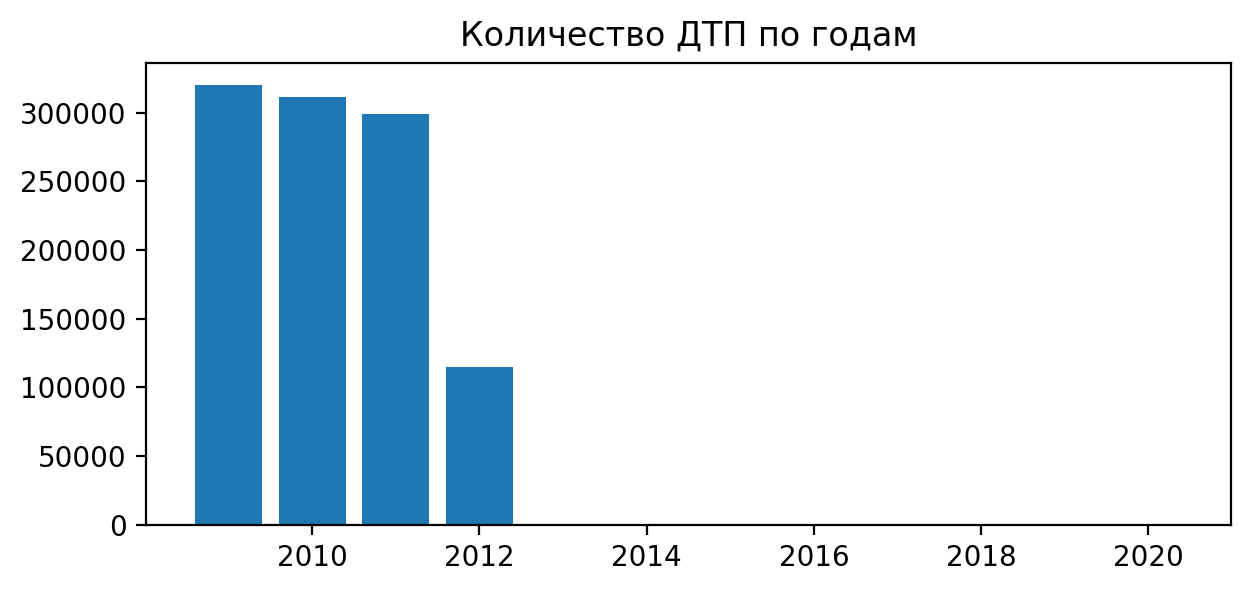

In [11]:
plt.figure(figsize=(7, 3))
plt.bar(_data.collision_year, _data.collisions_number)
plt.title("Количество ДТП по годам")
plt.show()

Мы видим, что в 2012 году количество ДТП уменьшилось в три раза и в последующие годы данные отсутствуют.

In [12]:
query = """
    SELECT 
        date_trunc('MONTH', c.collision_date)::date AS collision_month,
        count(DISTINCT(c.case_id)) AS collisions_number,
        MIN(EXTRACT('YEAR' FROM c.collision_date)) as year_number,
        MIN(EXTRACT('MONTH' FROM c.collision_date)) as month_number
    FROM parties p 
    JOIN collisions c ON p.case_id = c.case_id 
    WHERE p.party_type = 'car'
        AND c.collision_damage != 'scratch'
        AND c.collision_date BETWEEN '2009-01-01' AND '2012-12-31'
    GROUP BY date_trunc('MONTH', c.collision_date);
"""

_data = ds.exec_query(query)

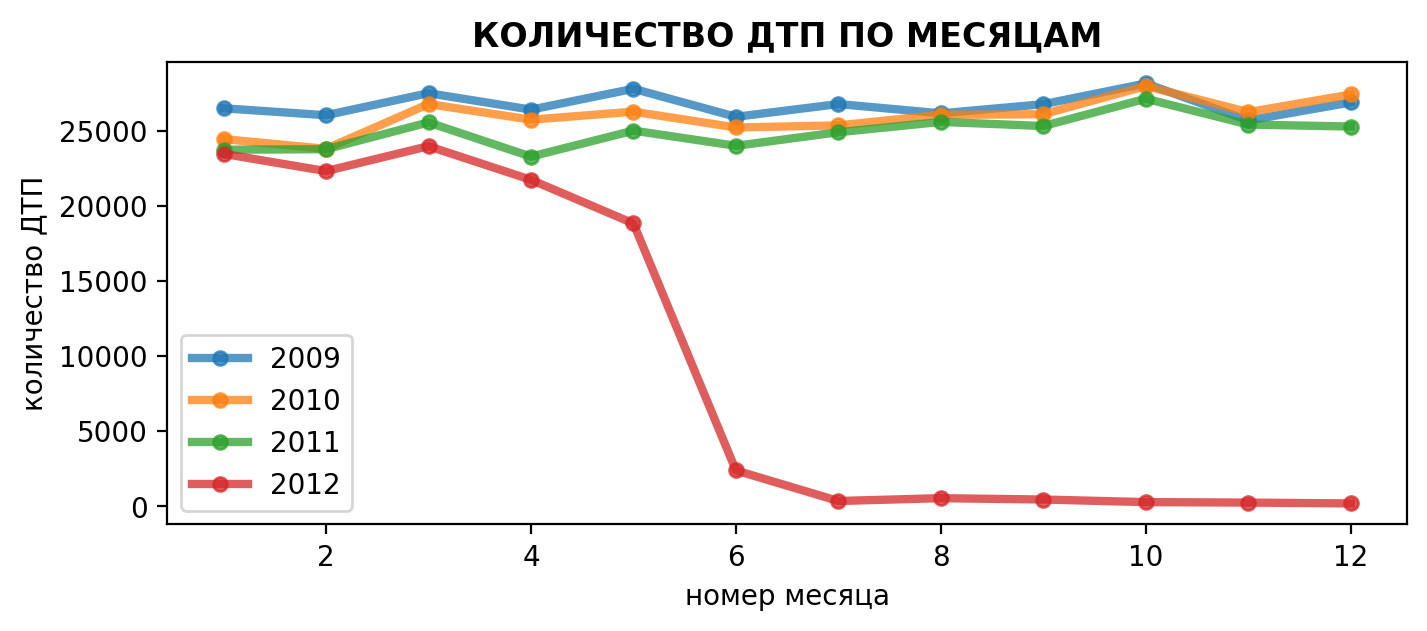

In [13]:
plt.figure(figsize=(8, 3))
for year in _data.year_number.unique():
    plt.plot(range(1, 13),
             _data[_data.year_number == year].collisions_number,
             lw=3,
             alpha=.75,
             marker="o",
             markersize=5,
             label=int(year))
plt.title("Количество ДТП по месяцам".upper(), fontweight="semibold")
plt.xlabel("номер месяца")
plt.ylabel("количество ДТП")
plt.legend(loc="lower left")
plt.show()

На этой диаграмме мы видим, что начиная с мая 2012 года количество ДТП в данных резко снижается. 

### Аналитические задачи

Создайте не менее шести задач, для решения должна использоваться связь не менее 2 таблиц, например
- Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
- Найдите самые частые причины ДТП (таблица parties).

Решим не менее двух задач самостоятельно

> Студент сам ставит аналитическую задачу. Как минимум должен записать шесть. А по 3-м из них создать запрос, построить график, сделать вывод

Поскольку у нас нет данных о поездках без аварий, мы не можем оценивать влияние на вероятность ДТП внешних условий: погода, локация, состояние дороги. Мы не знаем, как эти факторы влияют на интенсивность движения в целом. Изменение количества ДТП может быть связано с тем, например, что в плохую погоду, или в светлое время суток, люди больше или меньше ездят на автомобилях. Без информации об общем количестве поездок мы не можем делать вывод о влияние фактора на вероятность ДТП.

Поэтому сосредоточимся на факторах, относящихся к ДТП: 


1. Категория нарушения	PCF_VIOLATION_CATEGORY и Номер географических районов, где произошло ДТП	COUNTY_CITY_LOCATION
1. Основной фактор аварии	PRIMARY_COLL_FACTOR и Освещение	LIGHTING
1. Как соотносится Виновность участника	AT_FAULT с типом кузова Тип кузова	VEHICLE_TYPE
1. Как соотноится Виновность участника	AT_FAULT с Трезвость участника	PARTY_SOBRIETY
1. Как соотносится Виновность участника	AT_FAULT с Возраст автомобиля (в годах)	VEHICLE_AGE
1. Как соотносится Серьёзность происшествия	COLLISION_DAMAGE и Трезвость участника	PARTY_SOBRIETY



### Количество виновных и не виновных в ДТП

Изучим, как распределено количество ДТП по количеству виноватых и не виновтаых в каждом происшествии  сторон. 

Для каждого ДТП посчитаем количество виноватых и не виноватых в нем участников, а потом посчитаем количество ДТП для каждой комбинации количества виноват-не виноват. 

In [23]:
query = """
    WITH fault_combinations AS 
        (SELECT 
            c.case_id, 
            sum(p.at_fault) AS at_fault_number, 
            count(p.id) - sum(p.at_fault) AS not_fault_number
        FROM parties p 
        JOIN collisions c ON p.case_id = c.case_id 
        WHERE p.party_type = 'car'
            AND c.collision_damage != 'scratch'
            AND c.collision_date BETWEEN '2009-04-01' AND '2012-05-01'
        GROUP BY c.case_id)
    SELECT 
        at_fault_number,
        not_fault_number,
        count(case_id) AS collisions_num
    FROM fault_combinations
    GROUP BY 
        at_fault_number,
        not_fault_number
    ORDER BY count(case_id) DESC;
"""
_data = ds.exec_query(query)

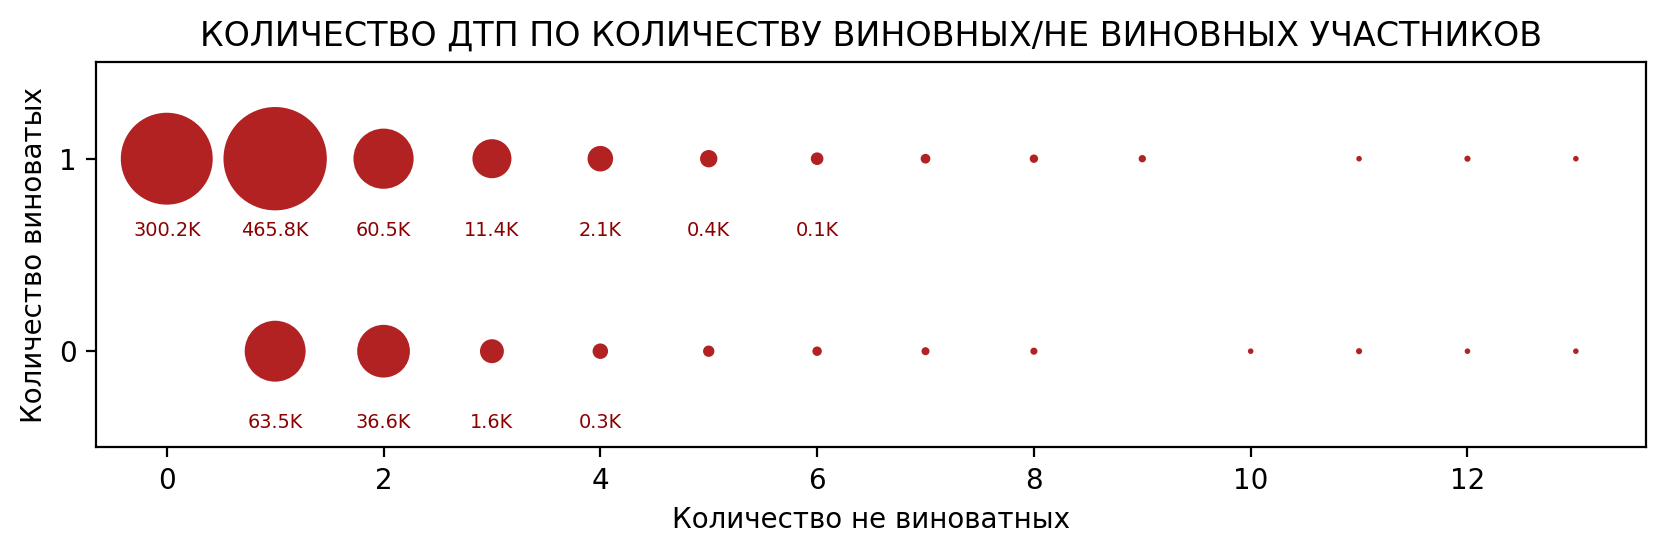

In [64]:
plt.figure(figsize=(10, 2.5))
plt.scatter(
    _data.not_fault_number,
    _data.at_fault_number,
    s=np.power(_data.collisions_num, .55),
    color="firebrick",
)
for i, r in _data.iterrows():
    if r["collisions_num"] < 1e2:
        continue
    plt.text(r["not_fault_number"],
             r["at_fault_number"] - .4,
             f'{r["collisions_num"]/1000:.1f}K',
             color="darkred",
             horizontalalignment="center",
             fontsize="x-small")

plt.yticks([0, 1])
plt.ylim(-.5, 1.5)
plt.title(
    "Количество ДТП по количеству виновных/не виновных участников".upper())
plt.ylabel("Количество виноватых")
plt.xlabel("Количество не виноватных")
plt.show()

Мы видим, что в нашем датасете количество виноватых в происшествии не превышает 1 водителя. При этом около 100 тыс. зафиксированных случаев не имеет виновника, только пострадавшего. 

Самая распространная ситуация: ДТП с одним виновным и одним невиновным водителем. Второе место по количеству ДТП занимают случаи, когда есть только виновный водитель.

Количество невиновных в ДТП варьируется в в диапазоне от 0 до 13. При этом ДТП с 5 невиновными и больше встречаются на три порядка реже, чем самые распространные случаи.

### Виновность и трезвость

Изучим, как соотносится Виновность участника AT_FAULT с Трезвость участника PARTY_SOBRIETY

Среди участников ДТП на автомобилях, для каждого значения трезовсти посчитаем количество учатсников, ставших винвниками ДТП и количество невиновных.

Рассчитаем [Aiffinity Index](https://medium.com/arocket/affinity-index-in-marketing-2badea3019c4) для каждого значения опьяния, приняв количество невиновых за общую группу, а количество виновных — за целевую. 

$ \mathit{AI} = \frac{\mathit{Target}}{\mathit{General}} \times 100\% $


In [65]:
query = """
    SELECT 
        p.party_sobriety,
        sum(p.at_fault) AS at_fault_number,
        count(p.id) - sum(p.at_fault) AS not_fault_number
    FROM parties p 
    JOIN collisions c ON p.case_id = c.case_id 
    WHERE p.party_type = 'car'
        AND c.collision_damage != 'scratch'
        AND c.collision_date BETWEEN '2009-04-01' AND '2012-05-01'
    GROUP BY p.party_sobriety;
"""
_data = ds.exec_query(query)

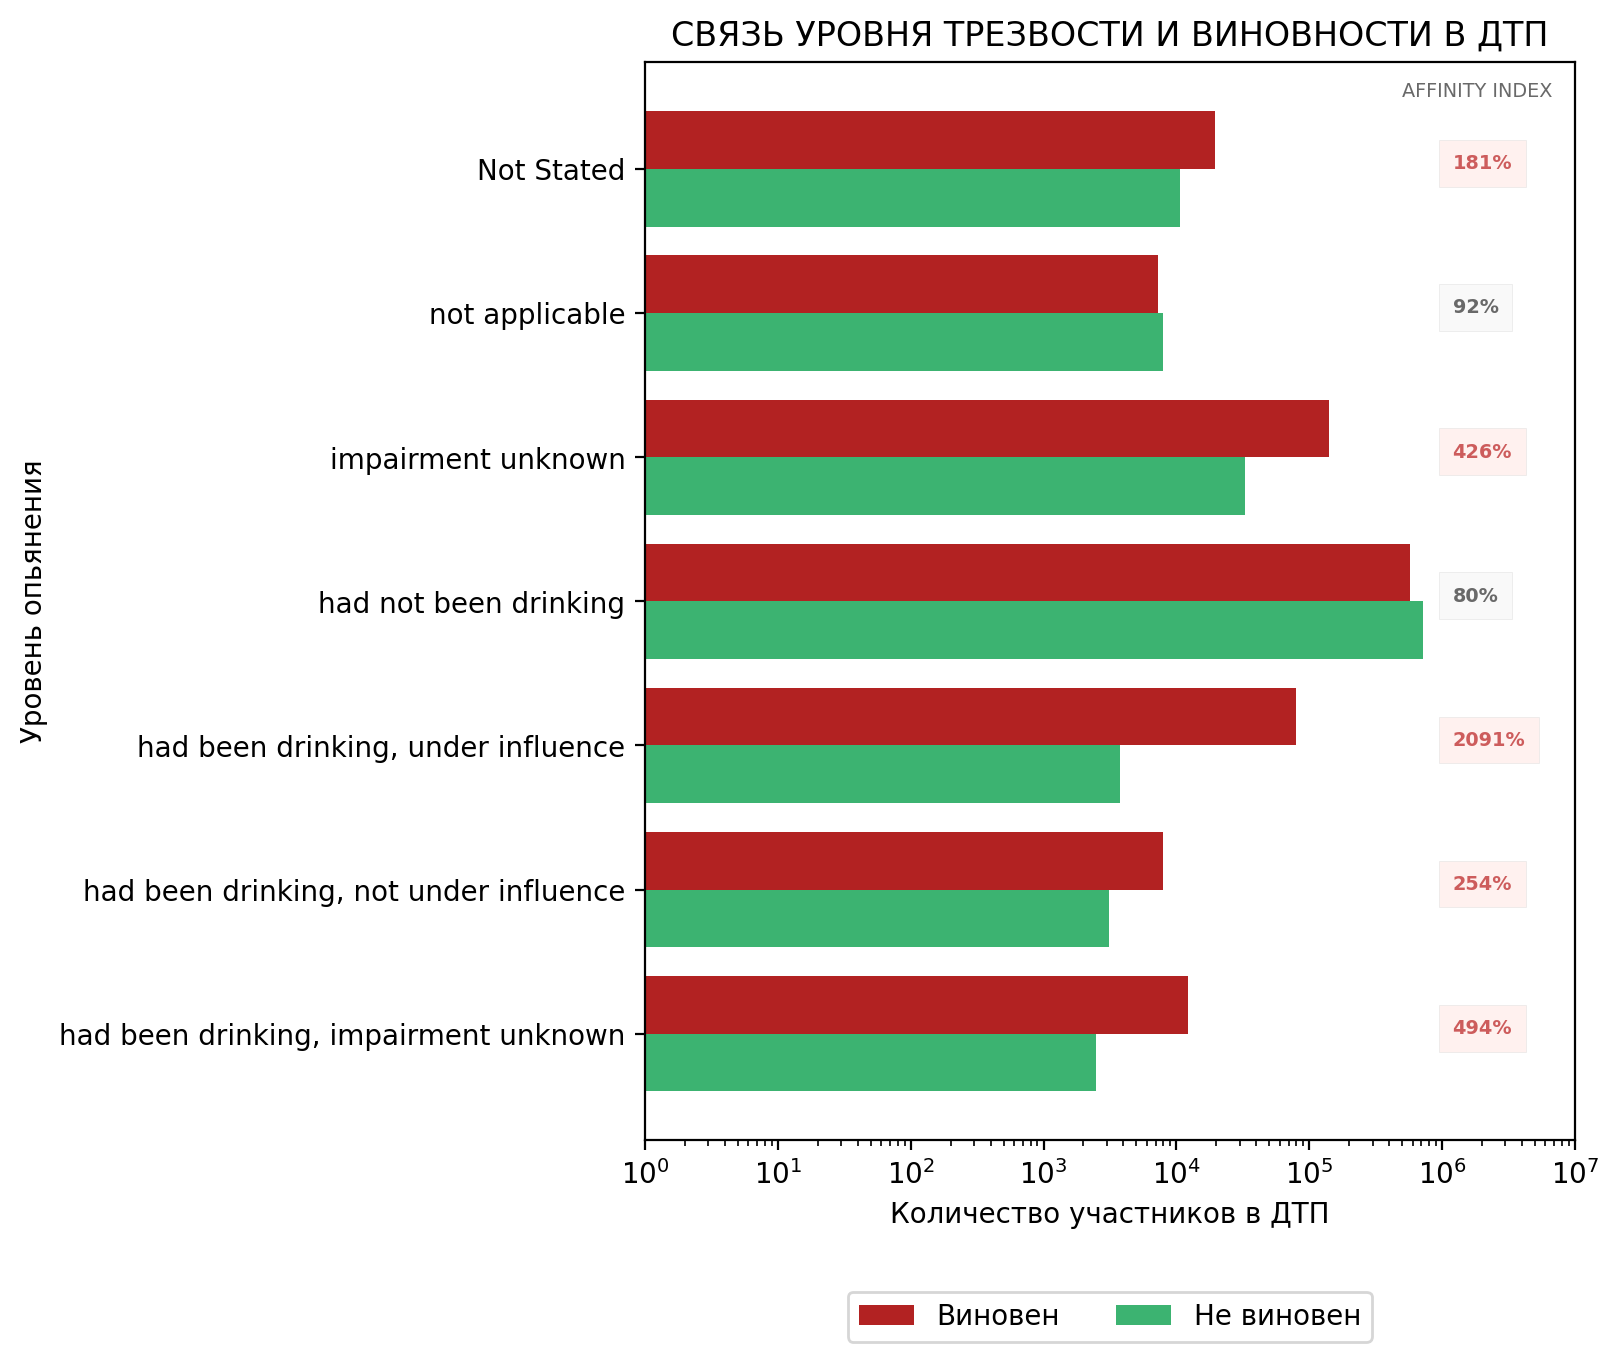

In [143]:
y = np.arange(0, _data.shape[0])
fig = plt.figure(figsize=(6, 7))
plt.barh(y + .2,
         width=_data.at_fault_number,
         height=.4,
         label="Виновен",
         color="firebrick")
plt.barh(y - .2,
         width=_data.not_fault_number,
         height=.4,
         label="Не виновен",
         color="mediumseagreen")

for i, r in _data.iterrows():
    ai = 100 * r["at_fault_number"] / r["not_fault_number"]
    if ai < 80 or ai > 120:
        facecolor = "mistyrose"
        fontcolor = "indianred"
    else:
        facecolor = "whitesmoke"
        fontcolor = "dimgrey"

    plt.text(1.2e6,
             i,
             f'{ai:.0f}%',
             fontsize="x-small",
             horizontalalignment="left",
             color=fontcolor,
             fontweight="bold",
             bbox={
                 'facecolor': facecolor,
                 'pad': 5,
                 'alpha': .5,
                 'edgecolor': 'lightgrey',
                 'lw': .25
             })
plt.yticks(y, _data.party_sobriety)
plt.ylabel("Уровень опьянения")
plt.xscale("log")
plt.xlim(1, 1e7)
plt.xlabel("Количество участников в ДТП")
plt.text(.5e6,
         6.5,
         "Affinity Index".upper(),
         fontsize="x-small",
         color="dimgrey")
plt.title("Связь уровня трезвости и виновности в ДТП".upper())
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

## Подготовка данных для моделирования

1. Подготовьте набор данных на основе первичного предположения заказчика:
- Выберите тип виновника — только машина (car). **
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.
- Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

2. Проведите первичный отбор факторов, необходимых для модели.
- Изучите описание факторов. Нужно отобрать те, которые могут влиять на вероятность ДТП. Будет хорошо, если вы аргументируете свой выбор. Пример:

```
columms =['party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
           ......
         ] 
```

3. Проведите статистическое исследование отобранных факторов.
- По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.
- Если необходимо, категоризируйте исходные данные, проведите масштабирование.
- Подготовьте обучающую и тестовую выборки.

## Модели оценки водительского риска

1. Смоделируйте не менее 3-х типов моделей с перебором гиперпараметров.
    1. 1–2 модели из числа линейные модели, деревья и леса;
    1. 1–2 модели из числа градиентных бустингов;
1. Выберите метрику для оценки модели, исходя из поставленной бизнесом задачи. Обоснуйте свой выбор.
1. Оформите вывод в виде сравнительной таблицы.

## Анализ важности факторов ДТП

1. Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.
1. Проанализируйте важность основных факторов, влияющих на вероятность ДТП.
1. Для одного из выявленных важных факторов проведите дополнительное исследование:
- Покажите график зависимости фактора и целевой переменной.
- Предложите, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.


Пример решения задачи 3:

Выявили, что самый важный фактор ДТП — уровень трезвости виновника party_sobriety. Из таблицы исходных данных известно: есть несколько уровней трезвости. Тогда решение по пунктам выглядит так:
- Для графического анализа будем использовать столбчатую диаграмму. В ней отразим зависимость числа ДТП от уровня трезвости. Проанализируем график, сделаем выводы.
- Предложить оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место.

## Вывод

Кратко опишите лучшую модель.

Сделайте вывод: насколько возможно создание адекватной системы оценки риска при выдаче авто?

Какие факторы ещё необходимо собирать, чтобы улучшить модель?